In [ ]:
!pip install transformers datasets evaluate accelerate peft trl bitsandbytes
!pip install nvidia-ml-py3

In [2]:
import os
import pandas as pd
import torch
from transformers import RobertaModel, RobertaTokenizer, TrainingArguments, Trainer, DataCollatorWithPadding, RobertaForSequenceClassification
from peft import LoraConfig, get_peft_model, PeftModel
from datasets import load_dataset, Dataset, ClassLabel
import pickle
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from torch.utils.data import DataLoader
import evaluate
from tqdm import tqdm
import matplotlib.pyplot as plt

In [ ]:
base_model = "roberta-base"

dataset = load_dataset("ag_news", split="train")
tokenizer = RobertaTokenizer.from_pretrained(base_model)

def preprocess(examples):
    tokenized = tokenizer(examples["text"], truncation=True, padding=True)
    return tokenized

tokenized_dataset = dataset.map(preprocess, batched=True,  remove_columns=["text"])
tokenized_dataset = tokenized_dataset.rename_column("label", "labels")

In [4]:
num_labels = dataset.features["label"].num_classes
class_names = dataset.features["label"].names
print(class_names)

# Create an id2label mapping
id2label = {i: label for i, label in enumerate(class_names)}

data_collator = DataCollatorWithPadding(tokenizer=tokenizer, return_tensors="pt")

['World', 'Sports', 'Business', 'Sci/Tech']


In [ ]:
model = RobertaForSequenceClassification.from_pretrained(base_model, id2label=id2label)

In [6]:
len(tokenized_dataset)

120000

In [7]:
split_datasets = tokenized_dataset.train_test_split(test_size=640, seed=42)
train_dataset = split_datasets["train"]
eval_dataset = split_datasets["test"]

In [8]:
peft_config = LoraConfig(
    r=8,
    lora_alpha=16,
    lora_dropout=.1,
    bias = "none",
    task_type="SEQ_CLS",
)

In [9]:
peft_model = get_peft_model(model, peft_config)
peft_model.print_trainable_parameters()

trainable params: 888,580 || all params: 125,537,288 || trainable%: 0.7078


In [10]:
def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    accuracy = accuracy_score(labels, preds)
    return { "accuracy": accuracy }

In [ ]:
output_dir = "results"
training_args = TrainingArguments(
    output_dir=output_dir,
    report_to=[],
    eval_strategy="steps",
    logging_steps=100,
    learning_rate=.0004,
    num_train_epochs=4,
    use_cpu=False,
    dataloader_num_workers=4,
    per_device_train_batch_size=24,
    per_device_eval_batch_size=64,
    optim="adamw_torch",
    gradient_checkpointing=False,
    gradient_checkpointing_kwargs={ "use_reentrant": True }
)

peft_lora_finetuning_trainer = Trainer(
    model=peft_model,
    args=training_args,
    compute_metrics=compute_metrics,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    data_collator=data_collator,
)

result = peft_lora_finetuning_trainer.train()

In [14]:
epochs, losses, eval_losses, eval_accs = [], [], [], []
for log in peft_lora_finetuning_trainer.state.log_history:
    if "eval_loss" in log:
        eval_losses.append(log["eval_loss"])
        eval_accs.append(log["eval_accuracy"])
    elif "loss" in log:
        losses.append(log["loss"])
        epochs.append(log["epoch"])

Max eval accuracy 0.93125


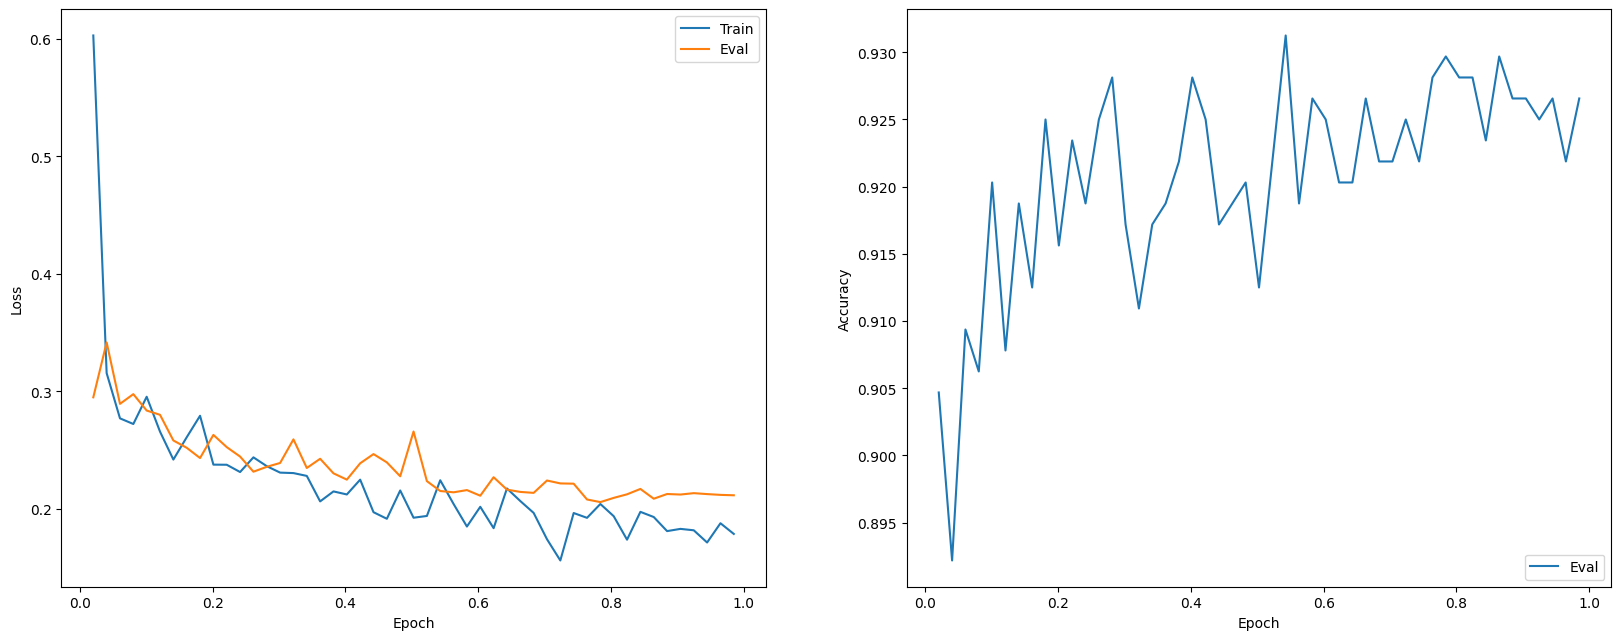

In [15]:
fig, ax = plt.subplots(1, 2, figsize=(20, 7.5))
ax[0].plot(epochs, losses, label="Train")
ax[0].plot(epochs, eval_losses, label="Eval")
ax[0].legend(loc="upper right")
ax[0].set_xlabel("Epoch")
ax[0].set_ylabel("Loss")
ax[1].plot(epochs, eval_accs, label="Eval")
ax[1].legend(loc="lower right")
ax[1].set_xlabel("Epoch")
ax[1].set_ylabel("Accuracy")
print(f"Max eval accuracy {max(eval_accs)}")
plt.savefig(os.path.join(output_dir,"output.png"))

In [16]:
def evaluate_model(inference_model, dataset, labelled=True, batch_size=8, data_collator=None):
    """
    Evaluate a PEFT model on a dataset.

    Args:
        inference_model: The model to evaluate.
        dataset: The dataset (Hugging Face Dataset) to run inference on.
        labelled (bool): If True, the dataset includes labels and metrics will be computed.
                         If False, only predictions will be returned.
        batch_size (int): Batch size for inference.
        data_collator: Function to collate batches. If None, the default collate_fn is used.

    Returns:
        If labelled is True, returns a tuple (metrics, predictions)
        If labelled is False, returns the predictions.
    """
    # Create the DataLoader
    eval_dataloader = DataLoader(dataset, batch_size=batch_size, collate_fn=data_collator)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    inference_model.to(device)
    inference_model.eval()

    all_predictions = []
    if labelled:
        metric = evaluate.load("accuracy")

    # Loop over the DataLoader
    for batch in tqdm(eval_dataloader):
        # Move each tensor in the batch to the device
        batch = {k: v.to(device) for k, v in batch.items()}
        with torch.no_grad():
            outputs = inference_model(**batch)
        predictions = outputs.logits.argmax(dim=-1)
        all_predictions.append(predictions.cpu())

        if labelled:
            # Expecting that labels are provided under the "labels" key.
            references = batch["labels"]
            metric.add_batch(
                predictions=predictions.cpu().numpy(),
                references=references.cpu().numpy()
            )

    # Concatenate predictions from all batches
    all_predictions = torch.cat(all_predictions, dim=0)

    if labelled:
        eval_metric = metric.compute()
        print("Evaluation Metric: ", eval_metric)
        return eval_metric, all_predictions
    else:
        return all_predictions

In [17]:
_, _, = evaluate_model(peft_model, eval_dataset, True, 8, data_collator)

100%|██████████| 80/80 [00:07<00:00, 11.39it/s]

Evaluation Metric:  {'accuracy': 0.9265625}


In [ ]:
unlabelled_dataset = pd.read_pickle("/kaggle/input/deep-learning-spring-2025-project-2/test_unlabelled.pkl")
test_dataset = unlabelled_dataset.map(preprocess, batched=True, remove_columns=["text"])

In [ ]:
preds = evaluate_model(peft_model, test_dataset, False, 8, data_collator)
df_output = pd.DataFrame({
    "ID": range(len(preds)),
    "Label": preds.numpy()
})
df_output.to_csv(os.path.join(output_dir,"output.csv"), index=False)